In [ ]:
# default_exp data.load 

In [ ]:
# hide
import sys

sys.path.append("..")

In [ ]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.tabular.core import *
from fastseq.data.transforms import *

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Data

> Using the pytorch dataset to make an easy dataset.


# Dataset

In [ ]:
# export
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

In [ ]:
# export
def pad_zeros(X, lenght):
    return  np.pad(
                X, 
                pad_width=((0, 0), (lenght - X.shape[-1], 0)), 
                mode='constant', 
                constant_values=0
            )

In [ ]:
# export
class TSTensorSeq(TensorSeq): pass
class TSTensorSeqy(TensorSeq): 
    
    @classmethod
    def create(cls, t)->None:
        "Convert an array or a list of points `t` to a `Tensor`"
        return cls(tensor(t).view(-1, 1).float())
    
    def show(self, ctx=None, **kwargs):
        if 'figsize' in kwargs: 
            del kwargs['figsize']
        array = np.array(self.cpu())
        array = no_emp_dim(array)
        x_len = self._meta.get('x_len',0)
        m = self._meta.get('m','-*r')
        ctx.plot(np.arange(x_len,x_len+len(array)), array, m, **kwargs)
        return ctx

In [ ]:
#export
TSTensorSeqyCreate = Transform(TSTensorSeqy.create)
TSTensorSeqyCreate.loss_func = MSELossFlat()
TSTensorSeqy.create = TSTensorSeqyCreate

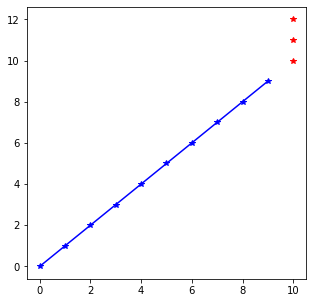

In [ ]:
ts = TSTensorSeq(np.arange(10))
ctx = ts.show()

y = TSTensorSeqy(np.array([10,11,12]), x_len=10)
y.show(ctx=ctx)

In [ ]:
# export
# TODO maybe incl. start where the last one ended and therefor keep hidden state
@delegates()
class TSDataLoader(TfmdDL):
    def __init__(self, time_series, horizon, lookback=72, step=1, bs=64,  num_workers=0, **kwargs):
        self.items, self.horizon, self.lookback, self.step = time_series, horizon, lookback, step   
        self.make_ids()
        super().__init__(dataset=time_series, bs=bs, num_workers=num_workers, **kwargs)

    def make_ids(self):        
        # Slice each time series into examples, assigning IDs to each
        last_id = 0
        n_dropped = 0
        self._ids = {}
        for i, ts in enumerate(self.items):
            if isinstance(ts,tuple):
                ts = ts[0] # no idea why they become tuples 
            num_examples = (ts.shape[-1] - self.lookback - self.horizon + self.step) // self.step
            # Time series shorter than the forecast horizon need to be dropped.
            if ts.shape[-1] < self.horizon:
                n_dropped += 1
                continue
            # For short time series zero pad the input
            if ts.shape[-1] < self.lookback + self.horizon:
                num_examples = 1
            for j in range(num_examples):
                self._ids[last_id + j] = (i, j * self.step)
            last_id += num_examples

            # Inform user about time series that were too short
        if n_dropped > 0:
            print("Dropped {}/{} time series due to length.".format(
                    n_dropped, len(self.items)))
        # Store the number of training examples
        self.n = int(self._ids.__len__() )
        
    def get_id(self,idx):        
        # Get time series
        ts_id, lookback_id = self._ids[idx]
        ts = self.items[ts_id]
        if isinstance(ts,tuple):
            ts = ts[0] # no idea why they become tuples 
        # Prepare input and target. Zero pad if necessary.
        if ts.shape[-1] < self.lookback + self.horizon:
            # If the time series is too short, we zero pad
            x = ts[:, :-self.horizon]
            x = np.pad(
                x, 
                pad_width=((0, 0), (self.lookback - x.shape[-1], 0)), 
                mode='constant', 
                constant_values=0
            )         
            y = ts[:,-self.horizon:]
        else:
            x = ts[:,lookback_id:lookback_id + self.lookback]
            y = ts[:,lookback_id + self.lookback:lookback_id + self.lookback + self.horizon]
        return x, y
        
    def shuffle_fn(self, idxs):
        self.items.shuffle()
        return idxs

    def create_item(self, idx):
        if idx>=self.n: raise IndexError
        x, y = self.get_id(idx)
        return TSTensorSeq(x),TSTensorSeqy(y, x_len=x.shape[1], m='-*g')


In [ ]:
# hide
horizon,lookback = 2,5
ints = L(np.arange(7)[None,:],np.arange(7,15)[None,:],np.arange(15,20)[None,:],np.arange(20,29)[None,:]).map(tensor)
dl = TSDataLoader(ints, horizon, lookback)
test_eq(list(dl),[(tensor([[[ 0,  1,  2,  3,  4]],[[ 7,  8,  9, 10, 11]],[[ 8,  9, 10, 11, 12]],[[ 0,  0, 15, 16, 17]]]), 
                   tensor([[[ 5,  6]],[[12, 13]],[[13, 14]],[[18, 19]]]))]
       )

In [ ]:
horizon,lookback = 2,5
ints = L(np.arange(7)[None,:],np.arange(7,15)[None,:],np.arange(15,20)[None,:],np.arange(20,29)[None,:]).map(tensor)
ints

(#4) [tensor([[0, 1, 2, 3, 4, 5, 6]]),tensor([[ 7,  8,  9, 10, 11, 12, 13, 14]]),tensor([[15, 16, 17, 18, 19]]),tensor([[20, 21, 22, 23, 24, 25, 26, 27, 28]])]

In [ ]:
dl = TSDataLoader(ints, horizon, lookback)
test_eq(list(dl),[(tensor([[[ 0,  1,  2,  3,  4]],[[ 7,  8,  9, 10, 11]],[[ 8,  9, 10, 11, 12]],[[ 0,  0, 15, 16, 17]]]), 
                   tensor([[[ 5,  6]],[[12, 13]],[[13, 14]],[[18, 19]]]))]
       )

In [ ]:
# hide
dl = TSDataLoader(ints, horizon, lookback, shuffle=True)
xy = tuple(dl)
test_eq(type(xy[0][0]), TSTensorSeq)

# Showing

In [ ]:
# export

from fastai2.vision.data import *

@typedispatch
def show_batch(x: TensorSeq, y, samples, ctxs=None, max_n=10,rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), rows=rows, cols=cols, add_vert=1, figsize=figsize)
    ctxs = show_batch[object](x, y, samples=samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs


# Intergration Example

In [ ]:
from fastseq.core import *
from fastseq.data.external import *
from fastseq.data.load import *
from fastai2.basics import *

In [ ]:
path = untar_data(URLs.m4_daily)
df_train = pd.read_csv(path/'train.csv',skiprows=skip)
df_test = pd.read_csv(path/'val.csv')
df_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
0,D1,2039.20,2035.00,2051.80,2061.8,2063.50,2069.5,2054.00,2057.00,2062.80,2066.40,2067.40,2071.40,2083.80,2080.60
1,D2,2986.00,3001.20,2975.90,2996.1,2981.90,2985.5,2975.80,2956.20,2964.70,2989.00,2991.40,3024.90,3070.80,3076.90
2,D3,1120.70,1117.90,1115.10,1112.3,1109.50,1106.7,1103.90,1101.10,1098.30,1095.50,1092.70,1089.90,1087.10,1084.30
3,D4,1190.00,1162.00,1134.00,1106.0,1078.00,1050.0,1022.00,994.00,966.00,938.00,910.00,1428.00,1400.00,1372.00
4,D5,5904.67,5917.05,5922.58,5928.8,5935.29,6002.8,6009.47,6014.82,6020.19,6072.49,6077.72,6080.23,6082.75,6108.07


In [ ]:
items = ts_lists(df_train.iloc[:,1:].values)

In [ ]:
horizon = 12
lookback = 128

In [ ]:
splits = RandomSplitter()(items)

((#352) [295,54,112,65,33,291,128,103,30,419...],
 (#88) [205,293,296,248,398,86,257,207,325,249...])

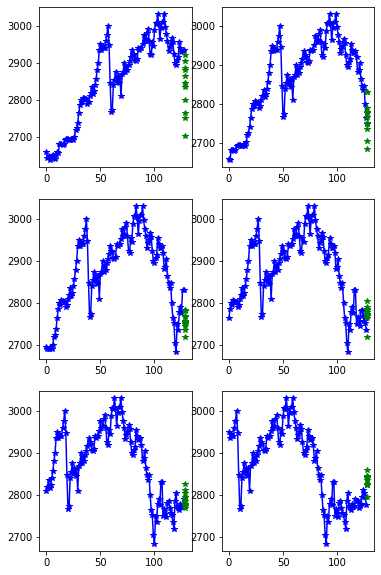

In [ ]:
dsrc = DataSource(items, splits=splits, dl_type=TSDataLoader)
dbunch = dsrc.databunch(bs=16, horizon=horizon, lookback=lookback, step=10)
dbunch.show_batch(max_n=6)

# TSDataBunch

In [ ]:
from fastseq.data.external import *
path = untar_data(URLs.m4_daily)
path.ls()

(#2) [Path('/home/tako/.fastai/data/m4_daily/train.csv'),Path('/home/tako/.fastai/data/m4_daily/val.csv')]

In [ ]:
#export
# TODO skip will skip different rows for train and val

def get_ts_files(path, recurse=True, folders=None, **kwargs):
    "Get image files in `path` recursively, only in `folders`, if specified."
    items = []
    for f in get_files(path, extensions=['.csv'], recurse=recurse, folders=folders):
        df = pd.read_csv(f, **kwargs)
        items.append(ts_lists(df.iloc[:, 1:].values))
    return items

In [ ]:
train, val = get_ts_files(path, nrows=1000)

In [ ]:
# export 
def concat_ts_list(train,val, lookback = 72):
    items=L()
    for t, v in zip(train,val):
        items.append(np.concatenate([t[:, -lookback:],v],1))
    return items

def sep_last(train, pct = .2):
    train,valid=L(),L()
    for ts in train:    
        split_idx = int(pct*ts.shape[1])   
        train.append(ts[:,:split_idx])
        valid.append(ts[:,split_idx:])
    return train, valid

In [ ]:
#export
def TSBlock():
    return TransformBlock(dl_type=TSDataLoader,)

In [ ]:
#export
class TSDataBunch(DataBunch):
    @classmethod
    @delegates(DataBunch.from_dblock)
    def from_folder(cls, path, valid_pct=None, seed=None, horizon=None, lookback=None, step=1, nrows=None, skiprows=None, **kwargs):
        "Create from M-compition style in `path` with `train`,`test` csv-files. "
        train, valid = get_ts_files(path, nrows=nrows, skiprows=skiprows)
        horizon = ifnone(horizon, len(valid[0]))
        lookback = ifnone(lookback, horizon * 3)
        test = concat_ts_list(train, valid, lookback)
        train, valid = sep_last(train, valid_pct)
        
        dsrc = DataSource(L(*train,*valid,*test), splits=[len(train),len(valid),len(test)], dl_type=TSDataLoader)
        return dsrc.databunch(bs=16, horizon=horizon, lookback=lookback, step=step)
    
#     @classmethod
#     @delegates(DataBunch.from_dblock)
#     def from_df(cls, df, path='.', valid_pct=0.2, seed=None, text_col=0, label_col=1, label_delim=None, y_block=None, 
#                 text_vocab=None, is_lm=False, valid_col=None, **kwargs):
#         if y_block is None and not is_lm: y_block = MultiCategoryBlock if is_listy(label_col) and len(label_col) > 1 else CategoryBlock
#         if is_lm: y_block = []
#         if not isinstance(y_block, list): y_block = [y_block]
#         splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)
#         dblock = DataBlock(blocks=(TextBlock(text_vocab, is_lm), *y_block),
#                            get_x=ColReader(text_col),
#                            get_y=None if is_lm else ColReader(label_col, label_delim=label_delim),
#                            splitter=splitter)
#         return cls.from_dblock(dblock, df, path=path, **kwargs)
    
#     @classmethod
#     def from_csv(cls, path, csv_fname='labels.csv', header='infer', delimiter=None, **kwargs):
#         df = pd.read_csv(Path(path)/csv_fname, header=header, delimiter=delimiter)
#         return cls.from_df(df, path=path, **kwargs)
    
# TextDataBunch.from_csv = delegates(to=TextDataBunch.from_df)(TextDataBunch.from_csv)

In [ ]:
TSDataBunch.from_folder(path, nrows=1000, horizon = 12)


TypeError: 'int' object is not iterable

In [ ]:
# hide
from nbdev.export import *

notebook2script()